In [26]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import zipfile
import os

# Path to the zip file on the google drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/lfw.zip'

# Path for unzipped file
extracted_path = './lfw/'

# Making directory for extraction
if not os.path.exists(extracted_path):
    os.makedirs(extracted_path)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

In [29]:
path = '/content/lfw/lfw'

In [30]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cuda:0


torch.Size([250, 250, 3])


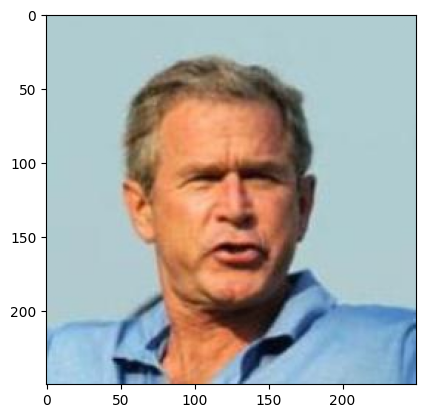

In [32]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

## **Autoencoders (AE) vs. Variational Autoencoders (VAE)**

### **Applications:**
1. **Autoencoders (AE):**
  *   **Reconstruction Tasks:** AEs are primarily used in tasks such as denoising, inpainting, and image compression, where the goal is to reconstruct the input data from a compressed representation.
  *   **Feature Learning:** AEs are helpful in learning meaningful representation of data, capturing important features for downstream tasks.

2. **Variational Autoencoders (VAE):**
  *   **Generative Modeling:** VAEs are very powerful generative models. Along with encoding the input data, it will also generate new samples by sampling from the learned latent space.
  *   **Uncertainity Data Generation:** VAEs provide us with a probabilistic framework, which helps in generation of data with inherent uncertainity. This is useful in applications where uncertainity in generated samples is critical, such as medical imaging.


### **Architecture:**
1. **Autoencoders (AE):**
  *   I have used the same architecture for both AE and VAE.
  *   3 Convolutional layers in Encoder along with the combination of ReLU activation function and 4 Transposed Convolutional layers along with the combination of ReLU and Sigmoid activation function.
  *   **Deterministic Encoder:** AE's encoder directly maps input data to a fixed-size latent representation.
  *   **Simple Decoder:** The decoder  reconstructs the input data based on the deterministic latent representation.

2. **Variational Autoencoders (VAE):**
  *   I have used the same architecture for both AE and VAE.
  *   3 Convolutional layers in Encoder along with the combination of ReLU activation function and 4 Transposed Convolutional layers along with the combination of ReLU and Sigmoid activation function.
  *   **Probabilistic Encoder:** VAE's encoder produces a distribution (mean and variance) in the latent space, introducing a stochastic element.
  *   **Sampling and Reparameterization:** VAE introduces a sampling step to produce latent variables, allowing for backpropagation through the sampling process, known as reparameterization trick.
  *   **KL Divergence Term:** VAE includes a KL divergence term in the loss function, encouraging the learned latent space to follow a specific distribution (typically Gaussian/Normal).


### **Loss Function:**
1. **Autoencoders (AE):**
  *   Both AE and VAE uses MSE Loss as a base.
  *   **Reconstruction Loss Only:** AE's loss function typically inclused only a reconstruction term(e.g., Mean Squared Error) measuring the difference between input and output.

2. **Variational Autoencoders (VAE):**
  *   Both AE and VAE uses MSE Loss as a base.
  *   **Reconstruction Loss + KL Divergence:** VAE's loss function comprises two components - the reconstruction loss (measuring the fidelity of reconstructed data) and the KL divergence term (enforcing a specific distribution on the latent space).
  *   **Balancing Trade-off:** The trade-off between reconstruction fidelity and latent space regularization is controlled by a hyperparameter (commonly denoted as beta).

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [33]:
import torch.nn as nn
import torch

class VAE(nn.Module):

    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # (32, 16, 125, 125)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (32, 32, 63, 63)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (32, 64, 32, 32)
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (32, 32, 64, 64)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),  # (32, 16, 127, 127)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1),  # (32, 8, 253, 253)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=1, padding=3),  # (32, 3, 250, 250)
            nn.Sigmoid(),
        )

        self.flatten = nn.Flatten()
        self.fc_mean = nn.Linear(64 * 32 * 32, latent_dim)
        self.fc_log_var = nn.Linear(64 * 32 * 32, latent_dim)
        self.fc_decoder = nn.Linear(latent_dim, 64 * 32 * 32, bias=True)

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.fc_mean(x)
        logvar = self.fc_log_var(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std_f = torch.exp(0.5 * logvar)
        z = torch.randn_like(mu) * std_f + mu
        return z

    def decode(self, z):
        z = self.fc_decoder(z)
        z = z.view(-1, 64, 32, 32)
        z = self.decoder(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In a Variational Autoencoder (VAE), generating new samples in the latent space involves utilizing the reparameterization trick, a key concept that facilitates the training of VAEs through backpropagation. The reparameterization trick is essential because it allows the model to generate new samples in a differentiable manner, enabling gradients to flow through the sampling process during training.

Here's a step-by-step explanation of generating new samples in the latent space:

1. **Encoding:**
   - The input data (e.g., an image) is passed through the encoder, obtaining the mean ($\mu$) and log-variance ($\log(\sigma^2)$) of the latent distribution.

2. **Reparameterization Trick:**
   - To generate new samples, we need to sample from the distribution defined by the mean and variance obtained from the encoder. However, directly sampling from a non-differentiable operation hinders backpropagation. The reparameterization trick introduces a differentiable transformation.
   - Instead of directly sampling, we sample from a standard normal distribution (N(0, 1)).
   - The sampled values ($ \epsilon $) are then transformed to obtain a sample from the desired distribution using the mean ($ \mu $) and standard deviation ($ \sigma $) obtained from the endoder. $ z = \mu + \epsilon \cdot \sigma $

3. **Decoding:**
   - The sampled values ($ z $) are then passed through the decoder to generate new data (e.g., a reconstructed image).
   - The decoder takes the sampled latent representation and produces an output that ideally resembles the input data.



In [34]:
# creating an instance of a new class
model = VAE(64).to(device)

In [35]:
sample = next(iter(dataloader))
image = sample[0][0].to(device)
encoder_output = model.forward(image.unsqueeze(0))
print("Encoder model has 2 outputs mean and variance")
print("Shape of mean: ", encoder_output[1].size())
print("Shape of variance: ", encoder_output[2].size())
print("Shape of Decoder (reconstructed image): ", encoder_output[0].shape)

Encoder model has 2 outputs mean and variance
Shape of mean:  torch.Size([1, 64])
Shape of variance:  torch.Size([1, 64])
Shape of Decoder (reconstructed image):  torch.Size([1, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [36]:
# printing the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 12711131


The loss function in a Variational Autoencoder (VAE) is typically composed of two main terms: the reconstruction loss and the Kullback-Leibler (KL) divergence term. Let's explore each term:

### 1. **Reconstruction Loss:**

* The reconstruction loss measures how well the VAE can reconstruct the input data. For pixel-based data like images, mean squared error (MSE) or binary cross-entropy is commonly used as a measure of dissimilarity between the original input and the reconstructed output.
* **Goal:** Minimizing the reconstruction loss encourages the VAE to produce reconstructions that closely resemble the input data. This term ensures that the VAE learns to encode and decode information effectively.

### 2. **KL Divergence Term:**
* The KL divergence term measures the divergence between the learned distribution of latent variables and a chosen prior distribution, usually a standard normal distribution.
* **Goal:** Minimizing the KL divergence term encourages the learned latent distribution to be close to the chosen prior. This promotes a structured and disentangled latent space, preventing it from overfitting or collapsing into degenerate solutions. The KL term acts as a regularizer, ensuring that the encoder does not assign arbitrary meanings to different regions of the latent space.


### 3. **Overall Objective:**
* The total loss is the sum of the reconstruction loss and the KL divergence term. This forms the overall objective that the VAE aims to minimize during training.
* **Goal:** Minimizing the overall loss guides the VAE to simultaneously produce accurate reconstructions and encourage a structured and informative latent space.


* create an optimizer for training

In [37]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [38]:
import torchvision.transforms.functional as Fa

print("device: ", device)

num_epochs = 10

model.train()

for epoch in range(num_epochs):
    total_loss = 0.0

    # Training loop
    for inputs, _ in dataloader:
        inputs = inputs.to(device)  # Move data to GPU
        optim.zero_grad()  # Zero the gradients
        outputs, mu_f, logvar_f = model.forward(inputs)  # Forward pass


        kl = -0.5 * (1 + logvar_f - mu_f.pow(2) - logvar_f.exp())
        kl_loss = kl.sum() / inputs.size(0)

        fit = 0.5 * (outputs - inputs).pow(2)
        fit_loss = fit.sum() / inputs.size(0)
        loss = kl_loss + fit_loss

        loss.backward()  # Backward pass

        optim.step()  # Update weights

        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(dataloader)

    # Print loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

device:  cuda:0
Epoch [1/10], Loss: 3450.0015830809366
Epoch [2/10], Loss: 1965.3369863021776
Epoch [3/10], Loss: 1782.242851810179
Epoch [4/10], Loss: 1639.4213018002717
Epoch [5/10], Loss: 1570.4039970066237
Epoch [6/10], Loss: 1530.930242418667
Epoch [7/10], Loss: 1500.857891580333
Epoch [8/10], Loss: 1474.1687073638473
Epoch [9/10], Loss: 1451.2098117404514
Epoch [10/10], Loss: 1430.9287778697728


If the loss is not decreasing as expected, we can check the below things:
1. **Increase or Decrease Model Complexity:**
  * Check whether the VAE architecture, including the size of the latent space, is appropriate for the task.
  * Try changing the number of layers and hidden units in the encoder and decoder.
2. **Tune Learning Rate:**
  * Adjust the learning rate as it impacts the convergence.
  * Try using different learning rate schedulers and optimizers.
3. **Check Loss Function:**
  * Check if the loss function is implemented correctly as it consists of reconstruction loss and also a KL divergence term. Ensure the weights between these terms are proper.
4. **Monitor Gradients:**
  * Check the gradients during training to ensure that they are neither too large not too small and avoid exploding/vanishing gradient problem.
5. **Regularization Technique:**
  * Apply regularization techniques to prevent overfitting. Dropout or weight regularization can be useful.
6. **Inspect Latent Space:**
  * Visualize the latent space to ensure it exhibits meaningful structure. If the latent space is collapsing, it may hinder the VAE's ability to generate diverse samples.
7. **Latent Space Dimension:**
  * Try experementing with different latent space dimensions.
8. **Hyperparameter Tuning:**
  * Reevaluate the hyperparameters such as the batch size, number of epochs, and model complexity.
9. **Model Implementation:**
  * Verify if the model is implemented properly without any errors.




##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

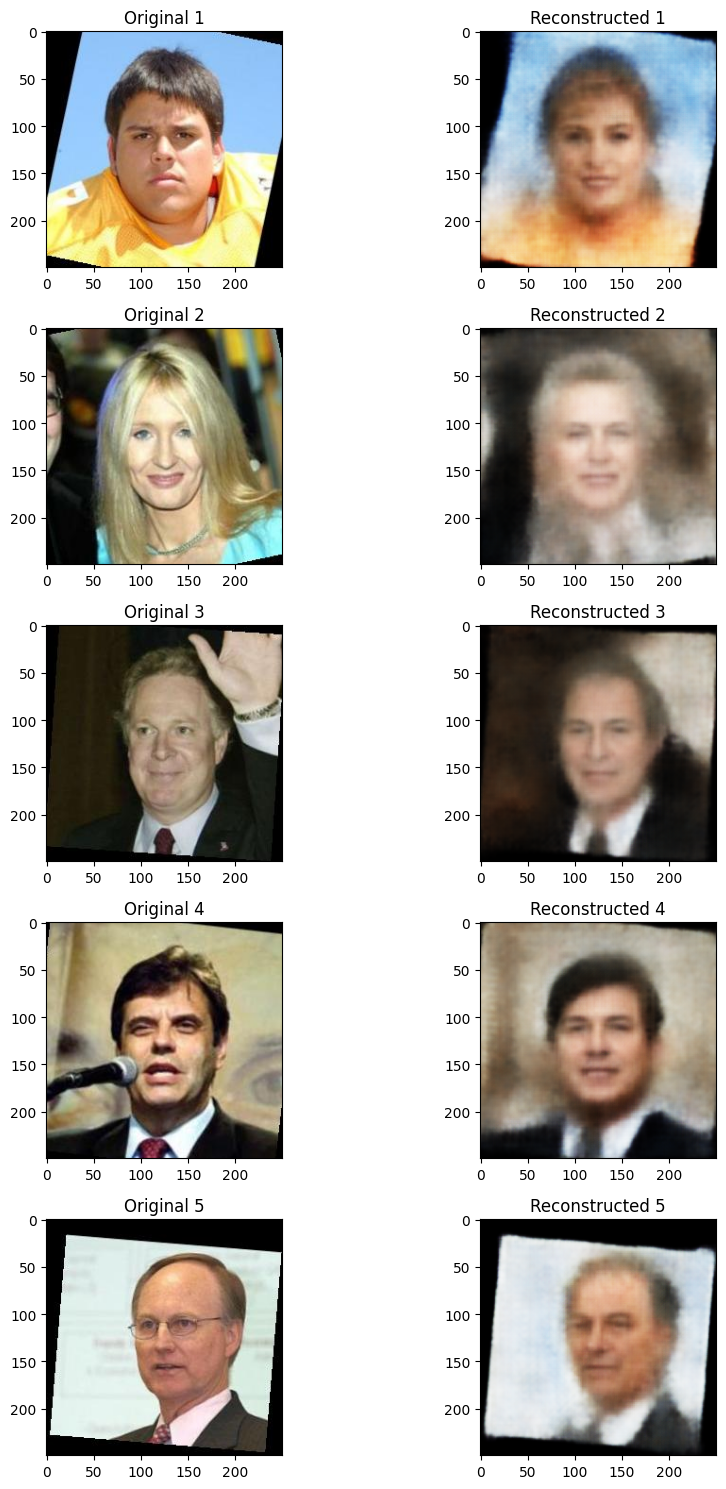

In [66]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Fa
from PIL import Image

# Assuming dataloader is your DataLoader and model is an instance of YourModel class
# model.eval()  # Set the model to evaluation mode

# Get 5 random images from the dataset
sample_images, _ = next(iter(dataloader))
sample_images = sample_images.to(device)
original_images = sample_images[:5].to(device)

# Pass the images through the VAE
with torch.no_grad():
    reconstructed_images, _, _ = model(original_images)

# Convert tensors to numpy arrays for plotting
original_images_np = [Fa.to_pil_image(img.cpu()) for img in original_images]
reconstructed_images_np = [Fa.to_pil_image(img.squeeze(0).cpu()) for img in reconstructed_images]

# Plot the original and reconstructed images side by side
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i, (original, reconstructed) in enumerate(zip(original_images_np, reconstructed_images_np)):
    axes[i, 0].imshow(original)
    axes[i, 0].set_title(f"Original {i + 1}")

    axes[i, 1].imshow(reconstructed)
    axes[i, 1].set_title(f"Reconstructed {i + 1}")

plt.tight_layout()
plt.show()